In [43]:
import os
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt


In [44]:
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'EOCprUG3A6FZFta9iUPXWYu8JQgjmY'
os.environ['mdate'] = '20220101 20231231'
os.environ['ticker'] = '2330'
!zipline ingest -b tquant


Merging daily equity files:
Currently used TEJ API key call quota 54/1000 (5.4%)
Currently used TEJ API key data quota 49595/10000000 (0.5%)


[2024-05-25 10:54:25.985418] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-25 10:54:29.022081] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [45]:
from zipline.api import (set_slippage, 
                         set_commission, 
                         set_benchmark, 
                         attach_pipeline, 
                         symbol, 
                         pipeline_output,
                         record, 
                         order,
                         order_target
                        )
from zipline.pipeline.filters import StaticSids
from zipline.finance import slippage, commission
from zipline import run_algorithm
from zipline.pipeline import CustomFactor, Pipeline
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import ExponentialWeightedMovingAverage

In [46]:
"""
Pipeline() 提供使用者快速處理多檔標的的量化指標與價量資料的功能，於本次案例我們用以處理:

股價的 7 日指數移動平均
過去 7 日的股價最高價 (自定義 factor 函式: NdaysMaxHigh)
過去 7 日的股價最低價 (自定義 factor 函式: NdaysMinLow)
當日收盤價
"""
def make_pipeline():
    ema = ExponentialWeightedMovingAverage(inputs = [EquityPricing.close],window_length = 7,decay_rate = 1/7)
    high = NdaysMaxHigh(inputs = [EquityPricing.close], window_length = 8) # window_length 設定為 8，因為 factor 會包含當日價格。
    low = NdaysMinLow(inputs = [EquityPricing.close], window_length = 8)
    close = EquityPricing.close.latest
    return Pipeline(
        columns = {
            'ema':ema,
            'highesthigh':high,
            'lowestlow':low,
            'latest':close
        }
    )
class NdaysMaxHigh(CustomFactor):
    def compute(self, today, assets, out, data):
        out[:] = np.nanmax(data[:-2], axis=0)
class NdaysMinLow(CustomFactor):
    def compute(self, today, assets, out, data):
        out[:] = np.nanmin(data[:-2], axis=0)

In [47]:
"""
建立 initialize 函式
inintialize 函式用於定義交易開始前的每日交易環境，與此例中我們設置:

流動性滑價
交易手續費
買入持有台積電的報酬作為基準
將 Pipeline 導入交易流程中
"""
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('2330'))
    attach_pipeline(make_pipeline(), 'mystrategy')

In [48]:

"""
建立 handle_date 函式
handle_data 函式用於處理每天的交易策略或行動，其中:

condition1: 當日收盤價大於過去 7 日最高價且產生正乖離時，產生賣出訊號。
condition2: 當日收盤價小於過去 7 日最低價且產生負乖離時，產生買入訊號
"""

def handle_data(context, data):
    
    pipe = pipeline_output('mystrategy')
    
    for i in pipe.index:
        ema = pipe.loc[i, 'ema']
        highesthigh = pipe.loc[i, 'highesthigh']
        lowestlow = pipe.loc[i, 'lowestlow']
        close = pipe.loc[i, 'latest']
        bias = close - ema
        residual_position = context.portfolio.positions[i].amount # 當日該資產的股數
        condition1 = (close > highesthigh) and (bias > 0) and (residual_position > 0) # 賣出訊號
        condition2 = (close < lowestlow) and (bias < 0) # 買入訊號
        
        record( # 用以紀錄以下資訊至最終產出的 result 表格中
            con1 = condition1,
            con2 = condition2,
            price = close,
            ema = ema,
            bias = bias,
            highesthigh = highesthigh,
            lowestlow = lowestlow
        )
    
        if condition1:
            order_target(i, 0)
        elif condition2:
            order(i, 10)
        else:
            pass


In [49]:
import matplotlib.pyplot as plt
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Price (NTD)")
    perf.price.plot(ax=ax2)
    ax2.plot( # 繪製買入訊號
        perf.index[perf.con2],
        perf.loc[perf.con2, 'price'],
        '^',
        markersize=5,
        color='red'
    )
    ax2.plot( # 繪製賣出訊號
        perf.index[perf.con1],
        perf.loc[perf.con1, 'price'],
        'v',
        markersize=5,
        color='green'
    )
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18,8)
    plt.show()


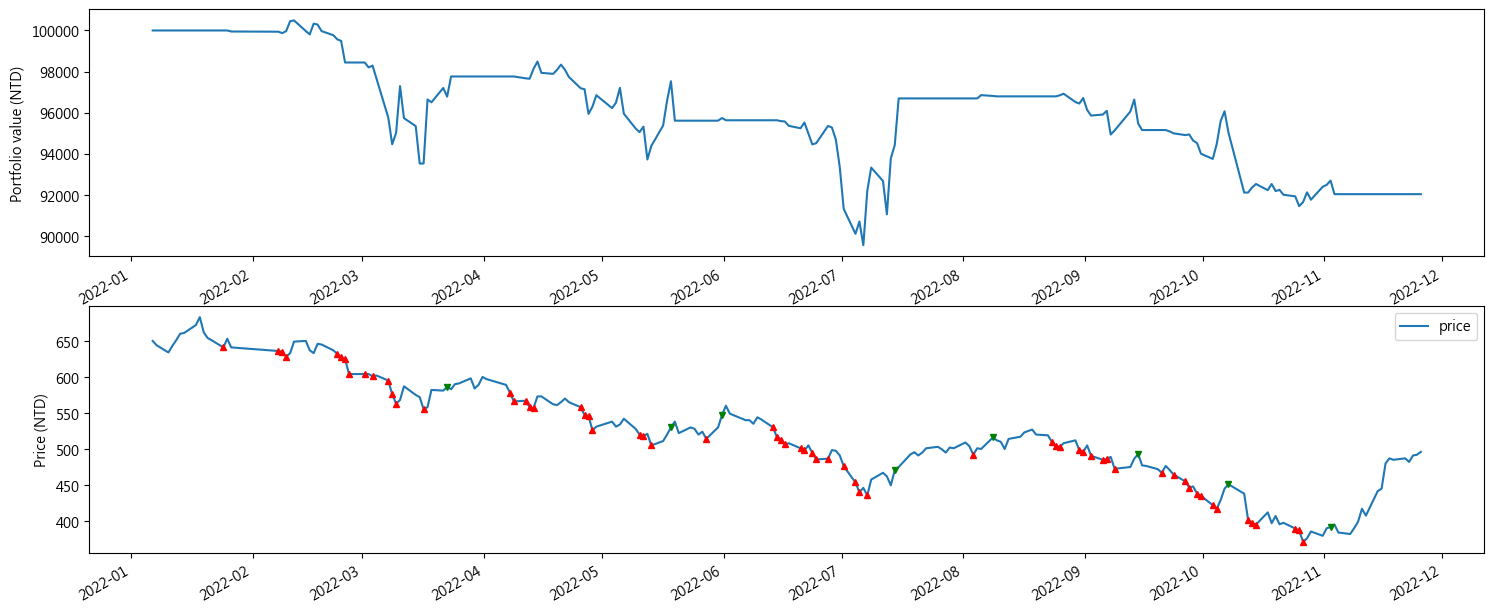

In [62]:
from zipline import run_algorithm


results = run_algorithm(start = pd.Timestamp('20220106', tz='UTC'),
                       end = pd.Timestamp('20221125', tz='UTC'),
                       initialize=initialize,
                       bundle='tquant',
                       analyze=analyze,
                       capital_base=1e5,
                       handle_data = handle_data
                      )



In [51]:
results # 績效與交易明細

,period_open,period_close,short_exposure,returns,gross_leverage,shorts_count,longs_count,treasury_return,capital_used,starting_value,...,beta,period_label,trading_days,algo_volatility,benchmark_period_return,excess_return,benchmark_volatility,sortino,sharpe,max_leverage
2022-01-06 13:30:00+08:00,2022-01-06 09:01:00+08:00,2022-01-06 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,NaN,2022-01,1,NaN,-0.009232,0.009232,NaN,NaN,NaN,0.000000
2022-01-07 13:30:00+08:00,2022-01-07 09:01:00+08:00,2022-01-07 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.000000,2022-01,2,0.000000,-0.024616,0.024616,0.070666,NaN,NaN,0.000000
2022-01-10 13:30:00+08:00,2022-01-10 09:01:00+08:00,2022-01-10 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.000000,2022-01,3,0.000000,-0.010771,0.010771,0.248637,NaN,NaN,0.000000
2022-01-11 13:30:00+08:00,2022-01-11 09:01:00+08:00,2022-01-11 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.000000,2022-01,4,0.000000,0.001538,-0.001538,0.239311,NaN,NaN,0.000000
2022-01-12 13:30:00+08:00,2022-01-12 09:01:00+08:00,2022-01-12 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.000000,2022-01,5,0.000000,0.015384,-0.015384,0.227907,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-21 13:30:00+08:00,2022-11-21 09:01:00+08:00,2022-11-21 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,4.156934,2022-11,214,10.155942,-0.246424,-0.550941,0.331029,-0.072691,-0.048360,459.885448
2022-11-22 13:30:00+08:00,2022-11-22 09:01:00+08:00,2022-11-22 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,4.139945,2022-11,215,10.132186,-0.232353,-0.565012,0.330948,-0.072522,-0.048248,459.885448
2022-11-23 13:30:00+08:00,2022-11-23 09:01:00+08:00,2022-11-23 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,4.139596,2022-11,216,10.108595,-0.230790,-0.566575,0.330194,-0.072354,-0.048136,459.885448
2022-11-24 13:30:00+08:00,2022-11-24 09:01:00+08:00,2022-11-24 13:30:00+08:00,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,4.136096,2022-11,217,10.085169,-0.224536,-0.572829,0.329575,-0.072187,-0.048026,459.885448


In [63]:

import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [64]:

returns

2022-01-06 00:00:00+00:00    0.0
2022-01-07 00:00:00+00:00    0.0
2022-01-10 00:00:00+00:00    0.0
2022-01-11 00:00:00+00:00    0.0
2022-01-12 00:00:00+00:00    0.0
                            ... 
2022-11-21 00:00:00+00:00    0.0
2022-11-22 00:00:00+00:00    0.0
2022-11-23 00:00:00+00:00    0.0
2022-11-24 00:00:00+00:00    0.0
2022-11-25 00:00:00+00:00    0.0
Name: returns, Length: 218, dtype: float64

In [65]:

positions

sid,Equity(0 [2330]),cash
index,,
2022-01-25 00:00:00+00:00,6410.0,93589.9715
2022-01-26 00:00:00+00:00,6360.0,93589.9715
2022-02-07 00:00:00+00:00,6350.0,93589.9715
2022-02-08 00:00:00+00:00,12560.0,87309.9430
2022-02-09 00:00:00+00:00,18990.0,80979.9145
...,...,...
2022-10-27 00:00:00+00:00,23130.0,68986.5230
2022-10-28 00:00:00+00:00,22770.0,68986.5230
2022-10-31 00:00:00+00:00,23400.0,68986.5230


In [66]:

transactions

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2022-01-25 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),641.0,c1298ae06e7348cf90529ca6aebfc42d,10,None,2022-01-25 13:30:00+08:00,-6410.0
2022-02-08 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),628.0,55d804f490834ddab4e09a2265478384,10,None,2022-02-08 13:30:00+08:00,-6280.0
2022-02-09 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),633.0,22e6c2b814b14273a39fab121dc2ce71,10,None,2022-02-09 13:30:00+08:00,-6330.0
2022-02-10 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),649.0,7efd3ed12551415389fe862540e8b34e,10,None,2022-02-10 13:30:00+08:00,-6490.0
2022-02-23 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),625.0,58211ad3de8742c7bb2bc577048769fb,10,None,2022-02-23 13:30:00+08:00,-6250.0
...,...,...,...,...,...,...,...,...
2022-10-17 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),397.0,b3164db33d2b44d78327335572caecb8,10,None,2022-10-17 13:30:00+08:00,-3970.0
2022-10-25 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),371.0,381319a24d3a4aabb5792e9d00281a4f,10,None,2022-10-25 13:30:00+08:00,-3710.0
2022-10-26 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),376.0,d7386e0017284144b6062e38baedf4dd,10,None,2022-10-26 13:30:00+08:00,-3760.0
2022-10-27 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),385.5,741e102fee1e4883835a42ca01f39628,10,None,2022-10-27 13:30:00+08:00,-3855.0


In [67]:
benchmark_rets = results['benchmark_return'] 
from pyfolio.utils import extract_rets_pos_txn_from_zipline
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

In [68]:
returns.head()

2022-01-06 00:00:00+00:00    0.0
2022-01-07 00:00:00+00:00    0.0
2022-01-10 00:00:00+00:00    0.0
2022-01-11 00:00:00+00:00    0.0
2022-01-12 00:00:00+00:00    0.0
Name: returns, dtype: float64

In [69]:
positions.head()

sid,Equity(0 [2330]),cash
index,,
2022-01-25 00:00:00+00:00,6410.0,93589.9715
2022-01-26 00:00:00+00:00,6360.0,93589.9715
2022-02-07 00:00:00+00:00,6350.0,93589.9715
2022-02-08 00:00:00+00:00,12560.0,87309.9430
2022-02-09 00:00:00+00:00,18990.0,80979.9145


In [70]:

transactions.head()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2022-01-25 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),641.0,c1298ae06e7348cf90529ca6aebfc42d,10,None,2022-01-25 13:30:00+08:00,-6410.0
2022-02-08 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),628.0,55d804f490834ddab4e09a2265478384,10,None,2022-02-08 13:30:00+08:00,-6280.0
2022-02-09 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),633.0,22e6c2b814b14273a39fab121dc2ce71,10,None,2022-02-09 13:30:00+08:00,-6330.0
2022-02-10 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),649.0,7efd3ed12551415389fe862540e8b34e,10,None,2022-02-10 13:30:00+08:00,-6490.0
2022-02-23 05:30:00+00:00,Equity(0 [2330]),Equity(0 [2330]),625.0,58211ad3de8742c7bb2bc577048769fb,10,None,2022-02-23 13:30:00+08:00,-6250.0


In [71]:
import pyfolio as pf 
perf_stats = pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

Start date,2022-01-06
End date,2022-11-25
Total months,10
,Backtest
Annual return,-9.159%
Cumulative returns,-7.974%
Annual volatility,11.474%
Sharpe ratio,-0.78
Calmar ratio,-0.84
Stability,0.59
Max drawdown,-10.896%


<Axes: ylabel='Cumulative returns'>

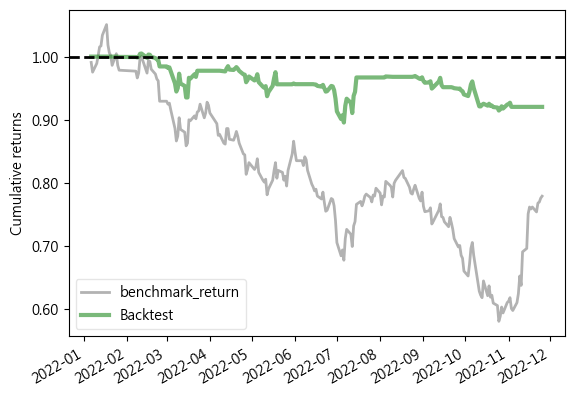

In [72]:
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_rets)